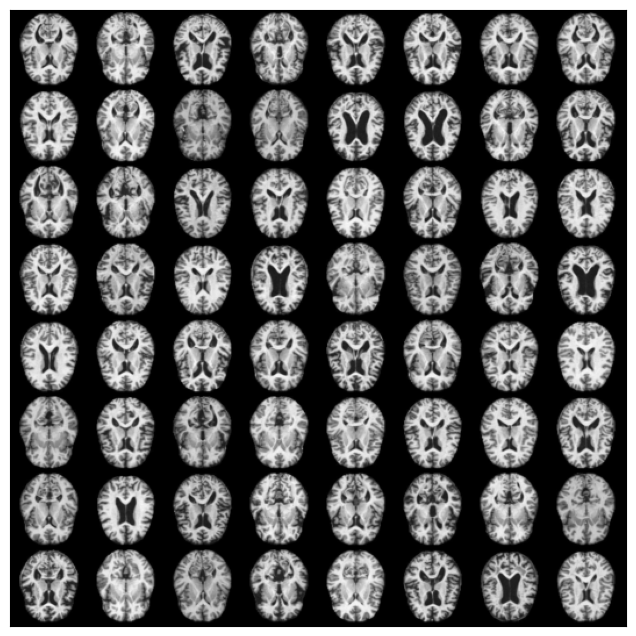

In [91]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets.folder import default_loader
import torchvision.transforms as T
import os
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Postavite putanje do direktorijuma sa slikama Demented
demented_data_dir = '../../datasets/images/original/train/NonDemented'

# Transformacije koje želite primeniti na slike
image_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
transform = T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
])

# Kreiranje Dataset klase za učitavanje slika direktno iz foldera
class ImageFolderDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.images = [f for f in os.listdir(root) if f.endswith(('png', 'jpg', 'jpeg'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root, self.images[idx])
        image = default_loader(img_name)
        if self.transform:
            image = self.transform(image)
        return image, 0  # Dummy label, možete promeniti labeliranje prema potrebi

# Kreiranje DataLoader-a za dataset Demented
batch_size = 128
demented_ds = ImageFolderDataset(demented_data_dir, transform=transform)
train_dl = DataLoader(demented_ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

# Prikaz slika iz DataLoader-a
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

# Prikaz slika iz DataLoader-a za dataset Demented
for images, _ in train_dl:
    show_images(images)
    break

plt.show()


In [92]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [93]:
device = get_default_device()
device

device(type='cpu')

In [94]:
train_dl = DeviceDataLoader(train_dl, device)

In [95]:
import torch.nn as nn

In [96]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [97]:
discriminator = to_device(discriminator, device)

In [98]:
latent_size = 128

In [99]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


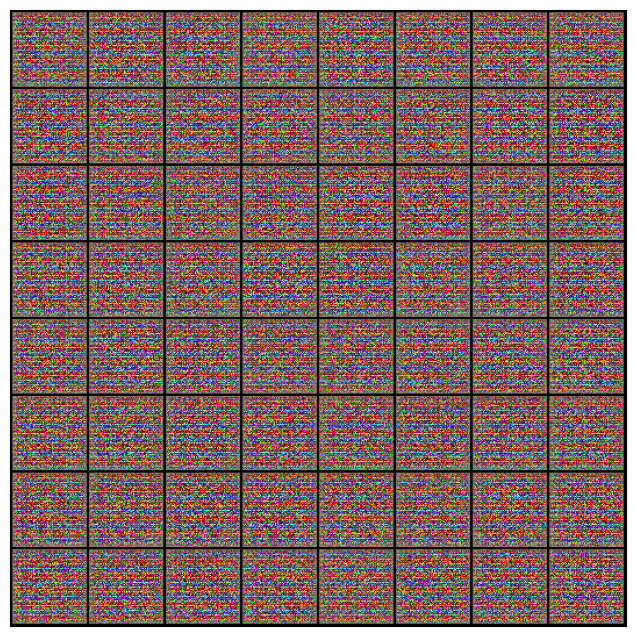

In [100]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [101]:
generator = to_device(generator, device)

In [102]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [103]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [104]:
from torchvision.utils import save_image

In [105]:
sample_dir = '../../datasets/images/generated/all'
os.makedirs(sample_dir, exist_ok=True)

In [106]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [107]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


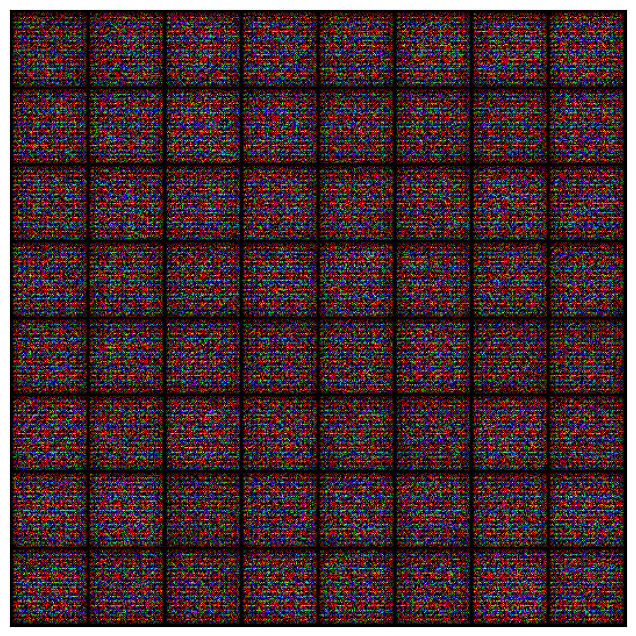

In [108]:
save_samples(0, fixed_latent)

In [109]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [110]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [111]:
lr = 0.0002
epochs = 50

In [112]:
import jovian
jovian.reset()
jovian.log_hyperparams(lr=lr, epochs=epochs)

[jovian] Hyperparams logged.


In [113]:
history = fit(epochs, lr)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 6.6725, loss_d: 0.0245, real_score: 0.9948, fake_score: 0.0190
Saving generated-images-0001.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 7.1532, loss_d: 0.0118, real_score: 0.9963, fake_score: 0.0080
Saving generated-images-0002.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 7.4697, loss_d: 0.0101, real_score: 0.9970, fake_score: 0.0070
Saving generated-images-0003.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 7.6668, loss_d: 0.0099, real_score: 0.9960, fake_score: 0.0059
Saving generated-images-0004.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 4.6798, loss_d: 0.0116, real_score: 0.9995, fake_score: 0.0111
Saving generated-images-0005.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 5.0799, loss_d: 2.6756, real_score: 0.0916, fake_score: 0.0012
Saving generated-images-0006.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 2.5943, loss_d: 0.4882, real_score: 0.7733, fake_score: 0.1755
Saving generated-images-0007.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 2.3272, loss_d: 0.3790, real_score: 0.7452, fake_score: 0.0688
Saving generated-images-0008.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 1.4588, loss_d: 0.4690, real_score: 0.7633, fake_score: 0.1741
Saving generated-images-0009.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 3.1718, loss_d: 1.3584, real_score: 0.9776, fake_score: 0.7106
Saving generated-images-0010.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 2.7989, loss_d: 0.4513, real_score: 0.7232, fake_score: 0.0866
Saving generated-images-0011.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 9.4651, loss_d: 2.3303, real_score: 0.9969, fake_score: 0.8868
Saving generated-images-0012.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 3.4278, loss_d: 0.9930, real_score: 0.4439, fake_score: 0.0347
Saving generated-images-0013.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 3.0780, loss_d: 0.5256, real_score: 0.6360, fake_score: 0.0462
Saving generated-images-0014.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 5.1547, loss_d: 0.8599, real_score: 0.9556, fake_score: 0.5408
Saving generated-images-0015.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 1.8686, loss_d: 0.6561, real_score: 0.7587, fake_score: 0.3039
Saving generated-images-0016.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 2.8937, loss_d: 0.3485, real_score: 0.8143, fake_score: 0.1209
Saving generated-images-0017.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 2.1285, loss_d: 0.5618, real_score: 0.6285, fake_score: 0.0549
Saving generated-images-0018.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [19/50], loss_g: 1.2778, loss_d: 0.9798, real_score: 0.4473, fake_score: 0.0900
Saving generated-images-0019.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [20/50], loss_g: 2.3313, loss_d: 0.7277, real_score: 0.5428, fake_score: 0.0717
Saving generated-images-0020.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [21/50], loss_g: 6.3659, loss_d: 0.5895, real_score: 0.9533, fake_score: 0.4035
Saving generated-images-0021.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 4.8330, loss_d: 0.8603, real_score: 0.9832, fake_score: 0.5527
Saving generated-images-0022.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 4.4522, loss_d: 0.7829, real_score: 0.8932, fake_score: 0.4756
Saving generated-images-0023.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 4.6477, loss_d: 1.4160, real_score: 0.9842, fake_score: 0.7386
Saving generated-images-0024.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 2.9135, loss_d: 1.1255, real_score: 0.9885, fake_score: 0.6295
Saving generated-images-0025.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 2.1087, loss_d: 0.7487, real_score: 0.5321, fake_score: 0.0591
Saving generated-images-0026.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 0.4385, loss_d: 0.5315, real_score: 0.6388, fake_score: 0.0446
Saving generated-images-0027.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 6.5520, loss_d: 0.7861, real_score: 0.9243, fake_score: 0.4961
Saving generated-images-0028.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 1.7788, loss_d: 0.5859, real_score: 0.5891, fake_score: 0.0168
Saving generated-images-0029.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 3.7918, loss_d: 0.3515, real_score: 0.9097, fake_score: 0.2206
Saving generated-images-0030.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 4.4561, loss_d: 3.4417, real_score: 0.0407, fake_score: 0.0016
Saving generated-images-0031.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 2.0044, loss_d: 0.5352, real_score: 0.6465, fake_score: 0.0596
Saving generated-images-0032.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 3.8633, loss_d: 0.3425, real_score: 0.8921, fake_score: 0.1978
Saving generated-images-0033.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [34/50], loss_g: 2.5343, loss_d: 0.7026, real_score: 0.6784, fake_score: 0.2498
Saving generated-images-0034.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [35/50], loss_g: 8.7146, loss_d: 1.0389, real_score: 0.9851, fake_score: 0.6196
Saving generated-images-0035.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [36/50], loss_g: 6.2777, loss_d: 4.3421, real_score: 0.0152, fake_score: 0.0005
Saving generated-images-0036.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [37/50], loss_g: 3.5278, loss_d: 0.8537, real_score: 0.9732, fake_score: 0.5490
Saving generated-images-0037.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [38/50], loss_g: 2.0498, loss_d: 0.6213, real_score: 0.9866, fake_score: 0.4425
Saving generated-images-0038.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [39/50], loss_g: 2.7941, loss_d: 0.3342, real_score: 0.7813, fake_score: 0.0699
Saving generated-images-0039.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [40/50], loss_g: 2.8721, loss_d: 0.0564, real_score: 0.9832, fake_score: 0.0384
Saving generated-images-0040.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [41/50], loss_g: 2.9796, loss_d: 0.3905, real_score: 0.9636, fake_score: 0.2888
Saving generated-images-0041.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [42/50], loss_g: 3.0566, loss_d: 0.3514, real_score: 0.8413, fake_score: 0.1559
Saving generated-images-0042.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [43/50], loss_g: 3.5127, loss_d: 1.7927, real_score: 0.2020, fake_score: 0.0058
Saving generated-images-0043.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [44/50], loss_g: 3.0978, loss_d: 0.3006, real_score: 0.8440, fake_score: 0.1119
Saving generated-images-0044.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [45/50], loss_g: 2.8522, loss_d: 0.1031, real_score: 0.9486, fake_score: 0.0479
Saving generated-images-0045.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [46/50], loss_g: 2.2387, loss_d: 0.3606, real_score: 0.8216, fake_score: 0.1451
Saving generated-images-0046.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [47/50], loss_g: 2.8176, loss_d: 2.8899, real_score: 0.0704, fake_score: 0.0035
Saving generated-images-0047.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [48/50], loss_g: 3.2931, loss_d: 2.4045, real_score: 0.1204, fake_score: 0.0030
Saving generated-images-0048.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [49/50], loss_g: 4.1074, loss_d: 0.0448, real_score: 0.9791, fake_score: 0.0231
Saving generated-images-0049.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [50/50], loss_g: 3.3708, loss_d: 0.2676, real_score: 0.9211, fake_score: 0.1667
Saving generated-images-0050.png


In [114]:
losses_g, losses_d, real_scores, fake_scores = history

In [115]:
jovian.log_metrics(loss_g=losses_g[-1], 
                   loss_d=losses_d[-1], 
                   real_score=real_scores[-1], 
                   fake_score=fake_scores[-1])

[jovian] Metrics logged.


In [116]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'model/G.pth')
torch.save(discriminator.state_dict(), 'model/D.pth')

In [117]:
import shutil

# Kreirajte direktorijum za čuvanje pojedinačnih slika
individual_images_dir = '../../datasets/images/generated/train/NonDemented'
if os.path.exists(individual_images_dir):
    shutil.rmtree(individual_images_dir)
os.makedirs(individual_images_dir, exist_ok=True)

# Funkcija za čuvanje pojedinačnih slika
def save_individual_images(generator, num_images, latent_size, save_dir, device):
    generator.eval()
    with torch.no_grad():
        for i in range(num_images):
            latent = torch.randn(1, latent_size, 1, 1, device=device)
            fake_image = generator(latent).cpu().detach()
            fake_image = denorm(fake_image)
            save_image(fake_image, os.path.join(save_dir, f'generated_image_{i+1:04d}.png'))
    print(f'Saved {num_images} images to {save_dir}')

# Sačuvajte 50 pojedinačnih slika nakon 30 epoha
save_individual_images(generator, 500, latent_size, individual_images_dir, device)


Saved 500 images to ../../datasets/images/generated/NonDemented


In [118]:
from IPython.display import Image

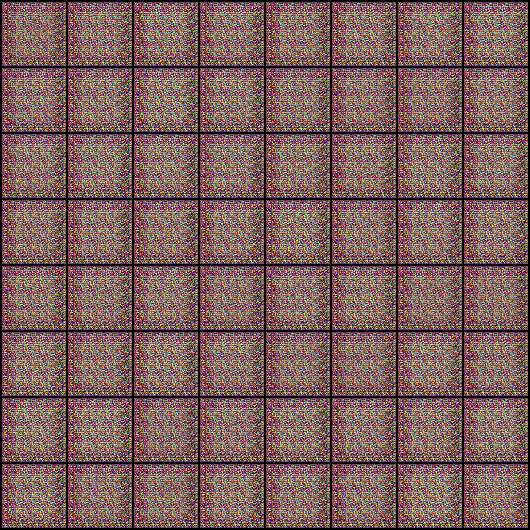

In [119]:
Image('../../datasets/images/generated/all/generated-images-0001.png')

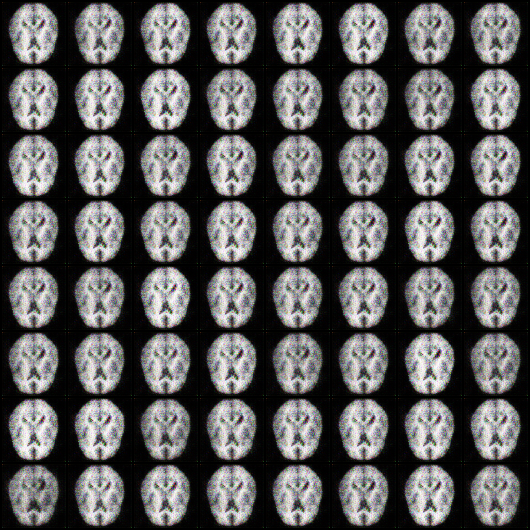

In [120]:
Image('../../datasets/images/generated/all/generated-images-0010.png')

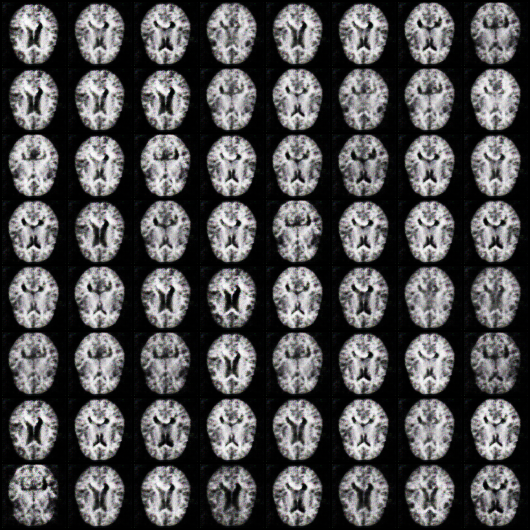

In [121]:
Image('../../datasets/images/generated/all/generated-images-0025.png')

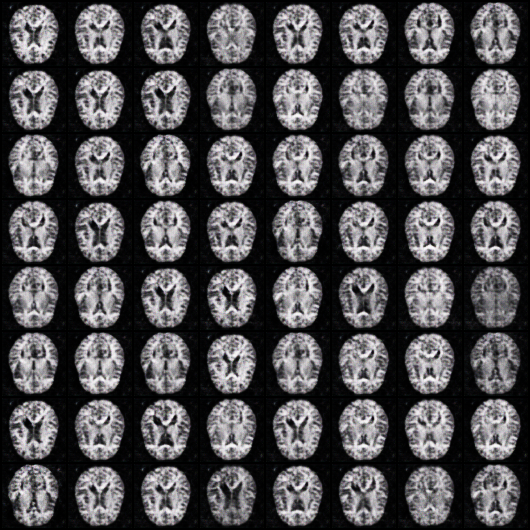

In [122]:
Image('../../datasets/images/generated/all/generated-images-0050.png')